In [1]:
from matplotlib import pyplot as plt
from matplotlib import cm
import numpy as np

In [2]:
class GridWorld:
    def __init__(self, size, start_cell, obstacles, terminating_state):
        self.size = size
        self.start = start_cell
        self.obstacles = obstacles
        self.termin = terminating_state
        self.current_cell = self.start
    
    def reset(self):
        self.current_cell = self.start
    
    def transition(self, cell, action):

        r_current = cell[0]
        c_current = cell[1]
        
        if action == 0:
          cell = (r_current,c_current-1)
        if action == 1:
          cell = (r_current-1,c_current)
        if action == 2:
          cell = (r_current,c_current+1)
        if action == 3:
          cell = (r_current+1,c_current)

        if (cell[0], cell[1]) in self.obstacles:
          cell = (r_current,c_current)

        if cell[0] < 0 \
             or cell[0] > self.size[0] -1 \
             or cell[1] < 0  \
             or cell[1] > self.size[1] -1 : 
          cell = (r_current, c_current)
        
        self.current_cell = cell
        
        return cell

    def reward(self, cell, action):
        cell_state = cell
        if self.transition(cell, action) != self.termin:
          reward = -1
        else:
          reward = 0
        self.current_cell = cell_state
        return reward

    def in_terminal(self):
        return self.current_cell == self.termin

In [3]:
class QLearning:
    def __init__(self, gridworld, gamma, alpha, episodes):
        self.gridworld = gridworld
        self.gamma = gamma
        self.alpha = alpha
        self.episodes = episodes
        size = gridworld.size
        self.q_table =  self.q_table = np.zeros((4,) + size)   
        self.eps = 0.9
        self.episode = 0
        self.sum_rewards = []
        self.path = []
    
    def update(self, cell, action, reward, next_cell):
        r_t, c_t = cell  # current state
        r_tp1, c_tp1 = next_cell  # next state
        q_current_step = self.q_table[action, r_t, c_t] 
        q_next_step = max(self.q_table[:, r_tp1, c_tp1])      
        error_term = reward + self.gamma * q_next_step - q_current_step
        self.q_table[action, r_t, c_t] = q_current_step + self.alpha * (error_term)
    
    def choose_action(self, cell):
        r, c = cell
        if np.random.random() > (1 - self.eps):
            action = np.argmax(self.q_table[:, r, c])
        else:
            action = np.random.randint(low=0, high=4)
        return action
    
    def anneal_epsilon(self):
        self.eps = max(0, self.eps * (1 - self.episode / self.episodes * 1.5))
    
    def one_episode(self):  
        cntr = 0   
        self.gridworld.reset()
        self.sum_rewards.append(0)
        while not self.gridworld.in_terminal() and cntr < 5000:
            cntr += 1
            cell = self.gridworld.current_cell
            action = self.choose_action(cell)
            reward = self.gridworld.reward(cell, action)
            next_cell = self.gridworld.transition(cell, action)
            self.update(cell, action, reward, next_cell)
            self.sum_rewards[-1] += reward

        print("Total Epi: {0: 5} Episode Steps: {1: 5} Reward: {2: 5.4f} ".format(
                    self.episode, cntr, self.sum_rewards[-1]))
        self.episode += 1
        self.anneal_epsilon

    def trajectory(self):
        self.gridworld.reset()
        self.path = []
        sum_rewards = 0
        itr = 0
        while not self.gridworld.in_terminal() and itr < 20:
            r, c = self.gridworld.current_cell
            action = np.argmax(self.q_table[:, r, c])
            sum_rewards += self.gridworld.reward((r, c), action)
            self.gridworld.transition((r, c), action)
            itr += 1
            self.path.append((r, c))
        return sum_rewards

    def is_learning_finished(self):  
        return self.episode > self.episodes

In [4]:
class Sarsa:
    
    def __init__(self, gridworld, gamma, alpha, episodes):
        self.gridworld = gridworld
        self.gamma = gamma
        self.alpha = alpha
        self.episodes = episodes
        size = gridworld.size
        self.q_table =  self.q_table = np.zeros((4,) + size) 
        self.eps = 0.9
        self.episode = 0
        self.sum_rewards = []
        self.path = []
    
    def update(self, cell, action, reward, next_cell, next_action):
        r_t, c_t = cell
        r_tp1, c_tp1 = next_cell  
        q_current_step = self.q_table[action, r_t, c_t] 
        q_next_step = self.q_table[next_action, r_tp1, c_tp1]
        error_term = reward + self.gamma * q_next_step - q_current_step    # TD Error
        self.q_table[action, r_t, c_t] = q_current_step + self.alpha * (error_term)
    
    def choose_action(self, cell):
        r, c = cell
        if np.random.random() > (1 - self.eps):
            action = np.argmax(self.q_table[:, r, c])
        else:
            action = np.random.randint(low=0, high=4)
        return action
    
    def anneal_epsilon(self):
        self.eps = max(0, self.eps * (1 - self.episode / self.episodes * 1.5))
    
    def one_episode(self):  
        first_step = True
        cntr = 0
        self.gridworld.reset()
        self.sum_rewards.append(0)

        while not self.gridworld.in_terminal() and cntr < 5000:
            cntr += 1
            cell = self.gridworld.current_cell
            
            if first_step == True:
                action = self.choose_action(cell)
                first_step = False
            else:
                action = next_action

            reward = self.gridworld.reward(cell, action)
            next_cell = self.gridworld.transition(cell, action) 
            next_action = self.choose_action(next_cell)
            self.update(cell, action, reward, next_cell, next_action)
            self.sum_rewards[-1] += reward

        print("Total Epi: {0: 5} Episode Steps: {1: 5} Reward: {2: 5.4f} ".format(
                    self.episode, cntr, self.sum_rewards[-1]))

        self.episode += 1
        self.anneal_epsilon
    
    def trajectory(self):
        self.gridworld.reset()
        self.path = []
        sum_rewards = 0
        itr = 0
        while not self.gridworld.in_terminal() and itr < 20:
            r, c = self.gridworld.current_cell
            action = np.argmax(self.q_table[:, r, c])
            sum_rewards += self.gridworld.reward((r, c), action)
            self.gridworld.transition((r, c), action)
            itr += 1
            self.path.append((r, c))
        return sum_rewards

    def is_learning_finished(self):
        return self.episode > self.episodes

In [5]:
def plot_learning_curve(ql):
    values = ql.sum_rewards
    x = list(range(len(values)))
    y = values
    plt.plot(x, y, 'ro')
    plt.show()

### Q Learner

In [6]:
size = (5, 5)
start_cell = (0, 0)
obstacles = [(2, 1), (1,3)]
terminating_state = (4, 4)
gamma = 0.9
alpha = 0.1
episodes = 220

gw = GridWorld(size, start_cell, obstacles, terminating_state)
solver = QLearning(gw, gamma, alpha, episodes)  

while not solver.is_learning_finished():
    solver.one_episode()
    sum_rewards = solver.sum_rewards[-1]

Total Epi:     0 Episode Steps:   134 Reward: -133.0000 
Total Epi:     1 Episode Steps:    26 Reward: -25.0000 
Total Epi:     2 Episode Steps:    52 Reward: -51.0000 
Total Epi:     3 Episode Steps:    38 Reward: -37.0000 
Total Epi:     4 Episode Steps:    78 Reward: -77.0000 
Total Epi:     5 Episode Steps:    67 Reward: -66.0000 
Total Epi:     6 Episode Steps:    49 Reward: -48.0000 
Total Epi:     7 Episode Steps:    13 Reward: -12.0000 
Total Epi:     8 Episode Steps:    22 Reward: -21.0000 
Total Epi:     9 Episode Steps:    90 Reward: -89.0000 
Total Epi:    10 Episode Steps:    15 Reward: -14.0000 
Total Epi:    11 Episode Steps:    53 Reward: -52.0000 
Total Epi:    12 Episode Steps:    23 Reward: -22.0000 
Total Epi:    13 Episode Steps:    23 Reward: -22.0000 
Total Epi:    14 Episode Steps:    37 Reward: -36.0000 
Total Epi:    15 Episode Steps:    59 Reward: -58.0000 
Total Epi:    16 Episode Steps:    13 Reward: -12.0000 
Total Epi:    17 Episode Steps:    23 Reward: -

-7


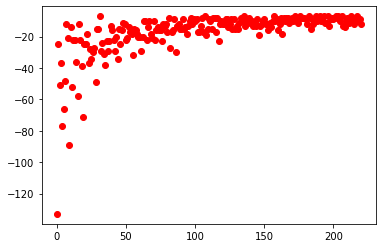

In [7]:
sum_rewards = solver.trajectory()
print(sum_rewards)
plot_learning_curve(solver)

In [8]:
count = 1
name_action = ["left", "up", "right", "down"]
for i in range (5):
    for k in range (5):
        action = name_action[np.argmax(solver.q_table[:,i,k])]
        print("state:", count, solver.q_table[:,i,k], action)
        count += 1

state: 1 [-4.77850136 -4.75835169 -4.7373933  -4.734882  ] down
state: 2 [-4.30894436 -4.28363035 -4.24108257 -4.2580982 ] right
state: 3 [-3.79070615 -3.76474605 -3.72217546 -3.73898276] right
state: 4 [-3.234809   -3.22666347 -3.23901968 -3.23378141] up
state: 5 [-2.73720184 -2.67009577 -2.65808478 -2.62873566] down
state: 6 [-4.29429706 -4.34286512 -4.24585895 -4.23998546] down
state: 7 [-3.90380132 -3.88663988 -3.84492377 -3.87785615] right
state: 8 [-3.25942141 -3.30702709 -3.29754619 -3.26106735] left
state: 9 [0. 0. 0. 0.] left
state: 10 [-1.89268163 -2.10362789 -1.97750082 -1.87930347] down
state: 11 [-3.75075556 -3.75967665 -3.74140027 -3.71180818] down
state: 12 [0. 0. 0. 0.] left
state: 13 [-2.71851869 -2.7343497  -2.57136785 -2.56689073] down
state: 14 [-1.83656164 -1.81670534 -1.81975805 -1.82345164] up
state: 15 [-1.33769886 -1.33347869 -1.03896314 -0.9995889 ] down
state: 16 [-3.16345602 -3.14414363 -3.11365382 -3.12212834] right
state: 17 [-2.52530448 -2.57271839 -2.492

### SARSA

In [9]:
size = (5, 5)
start_cell = (0, 0)
obstacles = [(2, 1)]
terminating_state = (4, 4)
gamma = 0.9
alpha = 0.1
episodes = 220

gw = GridWorld(size, start_cell, obstacles, terminating_state)
solver = Sarsa(gw, gamma, alpha, episodes)

while not solver.is_learning_finished():
    solver.one_episode()
    sum_rewards = solver.sum_rewards[-1]

Total Epi:     0 Episode Steps:   173 Reward: -172.0000 
Total Epi:     1 Episode Steps:    56 Reward: -55.0000 
Total Epi:     2 Episode Steps:    13 Reward: -12.0000 
Total Epi:     3 Episode Steps:    48 Reward: -47.0000 
Total Epi:     4 Episode Steps:    80 Reward: -79.0000 
Total Epi:     5 Episode Steps:    28 Reward: -27.0000 
Total Epi:     6 Episode Steps:    19 Reward: -18.0000 
Total Epi:     7 Episode Steps:    86 Reward: -85.0000 
Total Epi:     8 Episode Steps:    24 Reward: -23.0000 
Total Epi:     9 Episode Steps:    39 Reward: -38.0000 
Total Epi:    10 Episode Steps:    82 Reward: -81.0000 
Total Epi:    11 Episode Steps:    29 Reward: -28.0000 
Total Epi:    12 Episode Steps:    16 Reward: -15.0000 
Total Epi:    13 Episode Steps:    36 Reward: -35.0000 
Total Epi:    14 Episode Steps:    25 Reward: -24.0000 
Total Epi:    15 Episode Steps:    55 Reward: -54.0000 
Total Epi:    16 Episode Steps:    37 Reward: -36.0000 
Total Epi:    17 Episode Steps:    26 Reward: -

-20


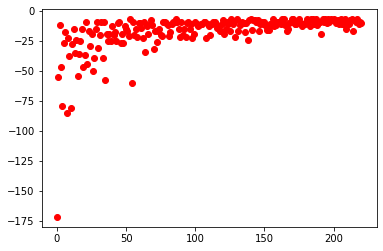

In [10]:
sum_rewards = solver.trajectory()
print(sum_rewards)
plot_learning_curve(solver)

In [11]:
count = 1
name_action = ["left", "up", "right", "down"]
for i in range (5):
    for k in range (5):
        action = name_action[np.argmax(solver.q_table[:,i,k])]
        print("state:", count, solver.q_table[:,i,k], action)
        count += 1

state: 1 [-4.73636577 -4.73192671 -4.64510361 -4.65193457] right
state: 2 [-4.27715998 -4.15878394 -4.12592096 -4.14289359] right
state: 3 [-3.65742235 -3.58902775 -3.5979282  -3.60007558] up
state: 4 [-3.05895217 -3.05098285 -3.05580474 -3.07214056] up
state: 5 [-2.59205449 -2.62394794 -2.73622198 -2.58358291] down
state: 6 [-4.22096787 -4.24668522 -4.15511044 -4.15798688] right
state: 7 [-3.81062005 -3.80844511 -3.7350075  -3.82915659] right
state: 8 [-3.15120305 -3.24767943 -3.16236928 -3.15566153] left
state: 9 [-2.65754427 -2.57953292 -2.58659187 -2.5801632 ] up
state: 10 [-2.12329561 -2.03392313 -1.98749161 -1.93154479] down
state: 11 [-3.67719372 -3.69247202 -3.65289327 -3.64558681] down
state: 12 [0. 0. 0. 0.] left
state: 13 [-2.58372914 -2.63392419 -2.50104793 -2.50785683] right
state: 14 [-1.93704491 -1.88555314 -1.86822276 -1.86155378] down
state: 15 [-1.19987523 -1.37793007 -1.32071331 -1.02680571] down
state: 16 [-3.07443054 -3.12202337 -3.06297952 -3.07688976] right
state